<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>baseline model</a></span></li><li><span><a href="#hyperparameter-tuning" data-toc-modified-id="hyperparameter-tuning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>hyperparameter tuning</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#test-score" data-toc-modified-id="test-score-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>test score</a></span></li></ul></li></ul></li></ul></div>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [4]:
df = pd.read_csv('data/time-series-datasets/Electric_Production.csv')

In [5]:
df.rename(columns = {"DATE":"Date","IPG2211A2N":"Daily Electricity Production"},inplace = True)

In [6]:
df.head()

,Date,Daily Electricity Production
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [7]:
df["Date"] = pd.to_datetime(df["Date"],infer_datetime_format = True)
df = df.set_index(["Date"])

In [8]:
from datetime import datetime
df.tail()

,Daily Electricity Production
Date,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [9]:
df.shape

(397, 1)

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


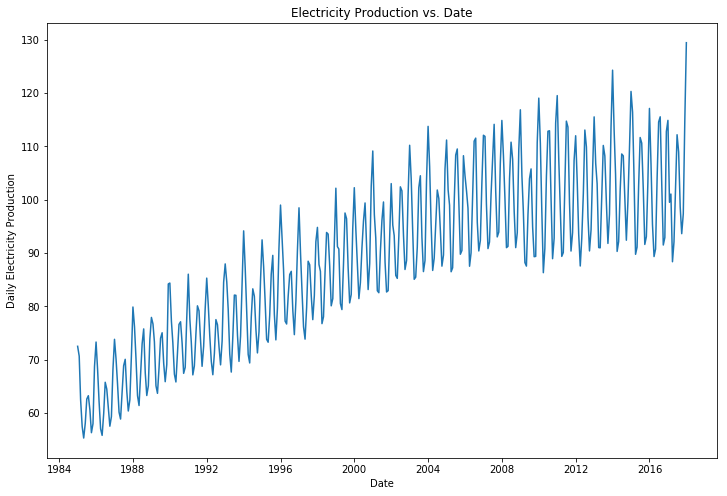

In [10]:
plt.figure(figsize = (12,8))
plt.ylabel("Daily Electricity Production")
plt.xlabel("Date")
plt.plot(df)
plt.title("Electricity Production vs. Date")
plt.show()

In [11]:
train_data = df[:317]
valid_data = df[317:357]
test_data = df[357:]

In [15]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_valid_data = scaler.transform(valid_data)
scaled_test_data = scaler.transform(test_data)

In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data,length=n_input,batch_size=1)

Using TensorFlow backend.


# baseline model

In [17]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout

lstm_model = Sequential()
lstm_model.add(LSTM(200,activation = "relu",input_shape = (n_input,n_features)))
lstm_model.add(Dropout(0))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer = "adam",loss = "mse")

In [18]:
lstm_model.fit_generator(generator,epochs = 20)

Epoch 1/20
287/287 [==============================] - 10s 35ms/step - loss: 0.0266
Epoch 2/20
287/287 [==============================] - 8s 27ms/step - loss: 0.0189
Epoch 3/20
287/287 [==============================] - 9s 32ms/step - loss: 0.0190
Epoch 4/20
287/287 [==============================] - 9s 33ms/step - loss: 0.0179
Epoch 5/20
287/287 [==============================] - 9s 32ms/step - loss: 0.0175
Epoch 6/20
287/287 [==============================] - 10s 33ms/step - loss: 0.0149
Epoch 7/20
287/287 [==============================] - 10s 33ms/step - loss: 0.0113
Epoch 8/20
287/287 [==============================] - 10s 33ms/step - loss: 0.0084
Epoch 9/20
287/287 [==============================] - 10s 33ms/step - loss: 0.0061
Epoch 10/20
287/287 [==============================] - 9s 33ms/step - loss: 0.0056
Epoch 11/20
287/287 [==============================] - 10s 34ms/step - loss: 0.0050
Epoch 12/20
287/287 [==============================] - 10s 34ms/step - loss: 0.0047
Epoch 

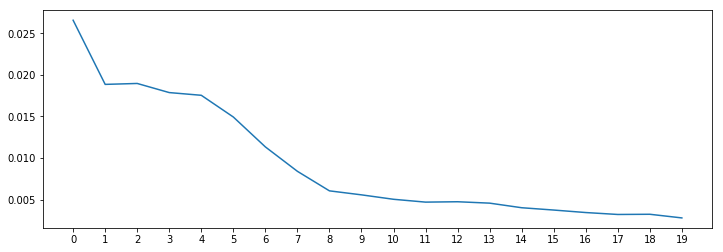

In [19]:
losses_lstm = lstm_model.history.history["loss"]
plt.figure(figsize = (12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [21]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape(1,n_input,n_features)

for i in range(len(valid_data)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis = 1)

In [22]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [24]:
lstm_predictions.reshape(40,)

array([106.01069023, 117.33432446, 113.5683796 , 100.73233921,
        91.56694757,  91.50129522, 103.73485175, 113.01268318,
       112.68754263,  99.74624581,  92.15229541,  93.8460679 ,
       108.03988487, 118.55535719, 114.12709777, 100.80840322,
        91.05451193,  92.7325866 , 106.38065598, 116.47432228,
       115.12943596, 101.97537336,  92.5941674 ,  94.81763394,
       109.42923303, 119.69707466, 114.40531701, 101.89371337,
        92.69467318,  94.19543219, 107.6225847 , 118.16127097,
       115.87225153, 102.58875847,  93.57147094,  94.95989345,
       107.49916333, 117.16343863, 115.10549909, 102.04330158])

In [25]:
valid_data["LSTM_Predictions"] = lstm_predictions

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


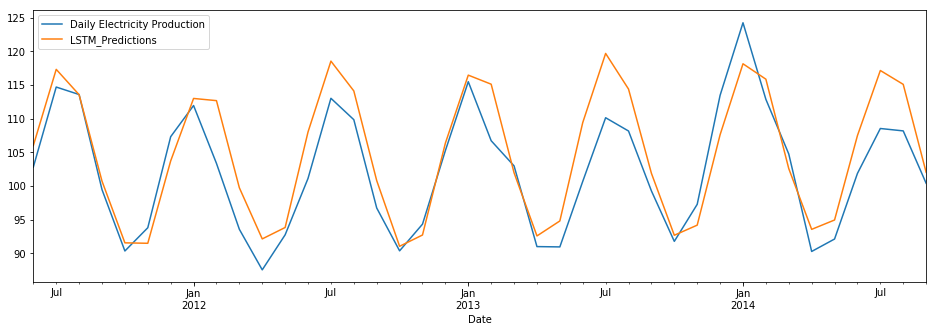

In [27]:
valid_data["Daily Electricity Production"].plot(figsize = (16,5),legend = True)
valid_data["LSTM_Predictions"].plot(legend = True)
# plt.plot(test_data["Daily Electricity Production"].values)
# plt.plot(lstm_predictions)

In [36]:
from statsmodels.tools.eval_measures import rmse,bias
pre = valid_data["LSTM_Predictions"].values
valid = valid_data["Daily Electricity Production"].values
lstm_smape_error = np.mean(abs(pre - valid) * 1.0 / (abs(pre) + abs(valid)) * 2)
lstm_rmse_error = rmse(valid,pre)
print(f"SMAPE Error: {lstm_smape_error}\nRMSE: {lstm_rmse_error}")

SMAPE Error: 0.036395986662183646
RMSE: 4.682718961321017


In [40]:
def fit_lstm(hidden_size,dropout_rate):
    lstm_model = Sequential()
    lstm_model.add(LSTM(hidden_size,activation = "relu",input_shape = (30,1)))
    lstm_model.add(Dropout(dropout_rate))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer = "adam",loss = "mse")
    lstm_model.fit_generator(generator,epochs = 20)
    
    lstm_predictions_scaled = list()

    batch = scaled_train_data[-n_input:]
    current_batch = batch.reshape(1,n_input,n_features)

    for i in range(len(valid_data)):
        lstm_pred = lstm_model.predict(current_batch)[0]
        lstm_predictions_scaled.append(lstm_pred)
        current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis = 1)
    lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
    return lstm_predictions.reshape(40,)

In [33]:
pre = lstm_predictions
val = valid_data["Daily Electricity Production"].values

In [34]:
def eval_fc(pre,val):
    smape = np.mean(abs(pre - valid) * 1.0 / (abs(pre) + abs(valid)) * 2)
    r = np.sqrt(np.mean(np.power((val-pre),2)))
    return smape,r

In [37]:
eval_fc(pre,val)

(0.036395986662183646, 4.682718961321017)

# hyperparameter tuning

In [38]:
hidden_sizes = [64,128,256]
dropout_rates = [0.1,0.2,0.3]

In [41]:
res_dic_fixed={}
for hidden_size in hidden_sizes:
    for dropout_rate in dropout_rates:
        open_price=fit_lstm(hidden_size,dropout_rate)
        res=eval_fc(open_price,valid)
        res_dic_fixed[hidden_size,dropout_rate]=res
        print(res_dic_fixed)

Epoch 1/20
287/287 [==============================] - 13s 45ms/step - loss: 0.0310
Epoch 2/20
287/287 [==============================] - 11s 39ms/step - loss: 0.0200
Epoch 3/20
287/287 [==============================] - 12s 42ms/step - loss: 0.0206
Epoch 4/20
287/287 [==============================] - 13s 44ms/step - loss: 0.0197
Epoch 5/20
287/287 [==============================] - 12s 42ms/step - loss: 0.0194
Epoch 6/20
287/287 [==============================] - 12s 41ms/step - loss: 0.0170
Epoch 7/20
287/287 [==============================] - 12s 41ms/step - loss: 0.0170
Epoch 8/20
287/287 [==============================] - 11s 39ms/step - loss: 0.0179
Epoch 9/20
287/287 [==============================] - 11s 39ms/step - loss: 0.0154
Epoch 10/20
287/287 [==============================] - 11s 39ms/step - loss: 0.0135
Epoch 11/20
287/287 [==============================] - 11s 39ms/step - loss: 0.0122
Epoch 12/20
287/287 [==============================] - 11s 39ms/step - loss: 0.0104
E

287/287 [==============================] - 7s 25ms/step - loss: 0.0173
Epoch 14/20
287/287 [==============================] - 7s 25ms/step - loss: 0.0165
Epoch 15/20
287/287 [==============================] - 7s 24ms/step - loss: 0.0142
Epoch 16/20
287/287 [==============================] - 7s 24ms/step - loss: 0.0123
Epoch 17/20
287/287 [==============================] - 7s 24ms/step - loss: 0.0123
Epoch 18/20
287/287 [==============================] - 7s 24ms/step - loss: 0.0122
Epoch 19/20
287/287 [==============================] - 7s 24ms/step - loss: 0.0096
Epoch 20/20
287/287 [==============================] - 7s 23ms/step - loss: 0.0097
{(64, 0.1): (0.04006334996099545, 5.246488220199863), (64, 0.2): (0.08192903728306669, 9.739985299231636), (64, 0.3): (0.07405139126408362, 8.947860204242508), (128, 0.1): (0.05744942458622686, 7.244599589710413), (128, 0.2): (0.07093969124704105, 8.377643819558877)}
Epoch 1/20
287/287 [==============================] - 8s 27ms/step - loss: 0.032

287/287 [==============================] - 8s 26ms/step - loss: 0.0090
Epoch 16/20
287/287 [==============================] - 7s 26ms/step - loss: 0.0084
Epoch 17/20
287/287 [==============================] - 8s 27ms/step - loss: 0.0078
Epoch 18/20
287/287 [==============================] - 7s 26ms/step - loss: 0.0076
Epoch 19/20
287/287 [==============================] - 8s 27ms/step - loss: 0.0075
Epoch 20/20
287/287 [==============================] - 7s 26ms/step - loss: 0.0077
{(64, 0.1): (0.04006334996099545, 5.246488220199863), (64, 0.2): (0.08192903728306669, 9.739985299231636), (64, 0.3): (0.07405139126408362, 8.947860204242508), (128, 0.1): (0.05744942458622686, 7.244599589710413), (128, 0.2): (0.07093969124704105, 8.377643819558877), (128, 0.3): (0.039997810497495484, 5.17803184185195), (256, 0.1): (0.051087640731227, 6.703010765496663), (256, 0.2): (0.05120267724338501, 6.083549204687168), (256, 0.3): (0.06471382983143854, 7.561677213598463)}


In [42]:
res_dic_fixed

{(64, 0.1): (0.04006334996099545, 5.246488220199863),
 (64, 0.2): (0.08192903728306669, 9.739985299231636),
 (64, 0.3): (0.07405139126408362, 8.947860204242508),
 (128, 0.1): (0.05744942458622686, 7.244599589710413),
 (128, 0.2): (0.07093969124704105, 8.377643819558877),
 (128, 0.3): (0.039997810497495484, 5.17803184185195),
 (256, 0.1): (0.051087640731227, 6.703010765496663),
 (256, 0.2): (0.05120267724338501, 6.083549204687168),
 (256, 0.3): (0.06471382983143854, 7.561677213598463)}

In [43]:
df_res_fixed = pd.DataFrame(res_dic_fixed,index=['smape','rmse']).T
df_res_fixed

smape      rmse
64  0.1  0.040063  5.246488
    0.2  0.081929  9.739985
    0.3  0.074051  8.947860
128 0.1  0.057449  7.244600
    0.2  0.070940  8.377644
    0.3  0.039998  5.178032
256 0.1  0.051088  6.703011
    0.2  0.051203  6.083549
    0.3  0.064714  7.561677

In [44]:
df_res_fixed.to_csv('eval.csv')

The best hyperparameter setting: hidden_size = 128, dropout_rate = 0.3

### test score

In [48]:
lstm_model = Sequential()
lstm_model.add(LSTM(128,activation = "relu",input_shape = (30,1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer = "adam",loss = "mse")
lstm_model.fit_generator(generator,epochs = 20)
    
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape(1,n_input,n_features)

for i in range(len(test_data)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis = 1)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

Epoch 1/20
287/287 [==============================] - 8s 30ms/step - loss: 0.0307
Epoch 2/20
287/287 [==============================] - 7s 24ms/step - loss: 0.0201
Epoch 3/20
287/287 [==============================] - 7s 24ms/step - loss: 0.0205
Epoch 4/20
287/287 [==============================] - 8s 26ms/step - loss: 0.0230
Epoch 5/20
287/287 [==============================] - 7s 25ms/step - loss: 0.0211
Epoch 6/20
287/287 [==============================] - 7s 24ms/step - loss: 0.0203
Epoch 7/20
287/287 [==============================] - 7s 25ms/step - loss: 0.0194
Epoch 8/20
287/287 [==============================] - 7s 25ms/step - loss: 0.0180
Epoch 9/20
287/287 [==============================] - 8s 27ms/step - loss: 0.0200
Epoch 10/20
287/287 [==============================] - 8s 26ms/step - loss: 0.0184
Epoch 11/20
287/287 [==============================] - 8s 27ms/step - loss: 0.0188
Epoch 12/20
287/287 [==============================] - 7s 25ms/step - loss: 0.0158
Epoch 13/20
2

In [52]:
eval_fc(lstm_predictions,test_data["Daily Electricity Production"].values)

(0.09329668752608654, 12.588545862869676)

In [54]:
test_data["LSTM_Predictions"]=lstm_predictions

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
np.save('lstm_electric',lstm_predictions.reshape(-1))

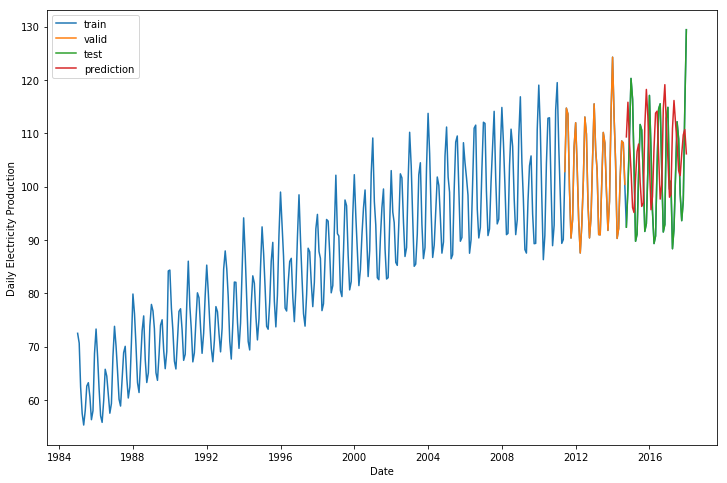

In [55]:
plt.figure(figsize = (12,8))
plt.ylabel("Daily Electricity Production")
plt.xlabel("Date")
plt.plot(df,label = 'train')
plt.plot(valid_data["Daily Electricity Production"],label='valid')
plt.plot(test_data["Daily Electricity Production"],label='test')
plt.plot(test_data["LSTM_Predictions"],label='prediction')
plt.legend()
plt.show()

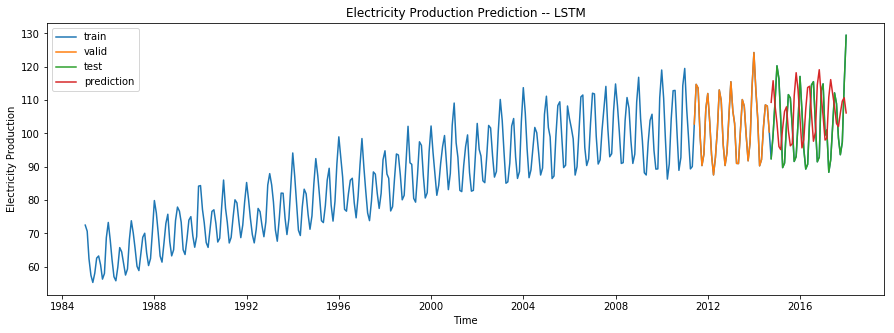

In [64]:
plt.figure(figsize = (15,5))
plt.ylabel("Electricity Production")
plt.xlabel("Time")
plt.plot(df,label = 'train')
plt.plot(valid_data["Daily Electricity Production"],label='valid')
plt.plot(test_data["Daily Electricity Production"],label='test')
plt.plot(test_data["LSTM_Predictions"],label='prediction')
plt.title("Electricity Production Prediction -- LSTM")
plt.legend()
plt.show()